# https://scib-metrics.readthedocs.io/en/latest/notebooks/lung_example.html

In [1]:
import sys
print(sys.version)
print(sys.executable)
import importlib
print(importlib.util.find_spec("scbiot"))
import scbiot as scb


3.12.8 (main, Jan 14 2025, 22:49:14) [Clang 19.1.6 ]
/home/figo/software/python_libs/scbiot/.venv/bin/python
ModuleSpec(name='scbiot', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7d019bf3e9f0>, origin='/home/figo/software/python_libs/scbiot/src/scbiot/__init__.py', submodule_search_locations=['/home/figo/software/python_libs/scbiot/src/scbiot'])


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as sc
import seaborn as sns
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
import torch
import os
import pandas as pd
import scbiot as scb
from scbiot.utils import set_seed

import harmonypy as hm
from umap import UMAP
# %pip install scib-metrics
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

set_seed(42)

from pathlib import Path
dir = Path.cwd()
print(dir)
parent_dir = dir.parent
print(parent_dir)


Random seed set as 42
/home/figo/software/python_libs/scbiot/examples
/home/figo/software/python_libs/scbiot


In [3]:
adata_path = f"{dir}/inputs/lung_atlas.h5ad"

adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/24539942",
)
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [4]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [5]:
# sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key='batch')
# sc.pp.scale(adata)
# sc.tl.pca(adata, n_comps=50, use_highly_variable=True)

sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3", batch_key='batch')
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.tl.pca(adata, n_comps=50, use_highly_variable=True)

In [6]:
adata, metrics = scb.ot.integrate(adata, modality='rna', obsm_key='X_pca', batch_key='batch', out_key='X_ot')
print(metrics)

[baseline] KNN backend=FAISS-GPU mix=0.5230 strain=0.00000
[iter 01] mix=0.697 overlap0=0.827 strain=0.00392 floor~0.600 J=0.258 best_it=1
[iter 02] mix=0.880 overlap0=0.702 strain=0.01115 floor~0.607 J=0.430 best_it=2
[iter 03] mix=1.046 overlap0=0.582 strain=0.02074 floor~0.613 J=0.563 best_it=3
[iter 04] mix=1.169 overlap0=0.482 strain=0.03205 floor~0.620 J=0.637 best_it=4
[iter 05] mix=1.238 overlap0=0.423 strain=0.04060 floor~0.627 J=0.670 best_it=5
[iter 06] mix=1.277 overlap0=0.379 strain=0.04936 floor~0.633 J=0.664 best_it=5
[iter 07] mix=1.281 overlap0=0.376 strain=0.04976 floor~0.640 J=0.657 best_it=5
[iter 08] mix=1.286 overlap0=0.381 strain=0.04820 floor~0.647 J=0.666 best_it=5
[early stop] plateau reached.
[final] it*=5 mix=1.238 overlap0=0.423 strain=0.04060 tw=0.983
{'mix': 1.237685723878865, 'overlap0': 0.4229733347892761, 'strain': 0.0406021885573864, 'tw': 0.9829403951925035, 'it': 5}


In [7]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'X_ot'
    varm: 'PCs'
    layers: 'counts'

In [8]:
# 1. Compute neighbors using Harmony-corrected PCA
sc.pp.neighbors(adata, use_rep='X_ot')

# 2. Run UMAP 
sc.tl.umap(adata)

# 3. Leiden clustering
sc.tl.leiden(adata, resolution=0.8, key_added='leiden_X_ot')
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'leiden_X_ot'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden_X_ot'
    obsm: 'X_pca', 'X_ot', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [9]:
adata.obs['leiden_X_ot'].value_counts()

leiden_X_ot
0     4690
1     3345
2     2983
3     2869
4     2693
5     2608
6     1955
7     1654
8     1494
9     1211
10     845
11     839
12     830
13     712
14     562
15     549
16     525
17     451
18     419
19     411
20     335
21     251
22     192
23      49
Name: count, dtype: int64

In [10]:
from sklearn.metrics import normalized_mutual_info_score

df = pd.DataFrame(adata.obsm['X_ot'], index=adata.obs.index) # adata.X.toarray()
df['batch'] = adata.obs['batch']

df['target'] = adata.obs['cell_type']
# Step 1: Get the counts of each category
category_counts = df['target'].value_counts()
# Step 2: Create a mapping of categories to numbers based on descending counts
category_mapping = {category: idx for idx, category in enumerate(category_counts.index)}
# Step 3: Map the original categorical column to the new numeric values
df['target'] = df['target'].map(category_mapping)

df['pseudo'] = adata.obs['leiden_X_ot']
# Step 1: Get the counts of each category
category_counts = df['pseudo'].value_counts()
# Step 2: Create a mapping of categories to numbers based on descending counts
category_mapping = {category: idx for idx, category in enumerate(category_counts.index)}
# Step 3: Map the original categorical column to the new numeric values
df['pseudo'] = df['pseudo'].map(category_mapping)

df = df.reset_index().set_index(['index', 'batch', 'target', 'pseudo'])

# Extract numeric labels
true_labels = df.reset_index()['target']
pred_labels = df.reset_index()['pseudo']

# Calculate NMI
nmi_score = normalized_mutual_info_score(true_labels, pred_labels)
print("NMI:", nmi_score)


NMI: 0.7103788547150558


In [11]:
# adata.write_h5ad(f'{dir}/cluster/lung/alldata.h5ad')

In [12]:
scb.pp.setup_anndata(adata, var_key='X_ot', batch_key='batch', pseudo_key='leiden_X_ot', true_key=None)

{'var_key': 'X_ot',
 'batch_key': 'batch',
 'pseudo_key': 'leiden_X_ot',
 'true_key': None}

In [13]:
model = scb.models.vae(adata, verbose=True)

Random seed set as 42
[Explicit labels] has_pseudo=True
[Explicit labels] batch_train/test: torch.Size([29224]) / torch.Size([3248])
[Explicit labels] pseudo_train/test: torch.Size([29224]) / torch.Size([3248])


In [14]:
model.train()

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Saved whole dataset latents (N=32472)


Training:   1%|▏         | 1/80 [00:03<04:34,  3.48s/it, epoch=1/80, Train_loss=1.9116, Test_loss=1.7588]

{'Train NMI': 0.244, 'Train ARI': 0.112, 'Train ACC': 0.232, 'Train kBET': 0.934, 'Train CCR': 0.0}


Training:   2%|▎         | 2/80 [00:04<02:57,  2.27s/it, epoch=2/80, Train_loss=2.6710, Test_loss=2.4222]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.311, 'Train ARI': 0.153, 'Train ACC': 0.253, 'Train kBET': 0.921, 'Train CCR': 0.065}


Training:   4%|▍         | 3/80 [00:06<02:25,  1.89s/it, epoch=3/80, Train_loss=3.0214, Test_loss=2.7572]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.41, 'Train ARI': 0.219, 'Train ACC': 0.341, 'Train kBET': 0.86, 'Train CCR': 0.0}


Training:   5%|▌         | 4/80 [00:08<02:18,  1.83s/it, epoch=4/80, Train_loss=3.2475, Test_loss=3.0476]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.492, 'Train ARI': 0.287, 'Train ACC': 0.363, 'Train kBET': 0.711, 'Train CCR': 0.086}


Training:   6%|▋         | 5/80 [00:09<02:05,  1.68s/it, epoch=5/80, Train_loss=3.7960, Test_loss=3.5836]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.516, 'Train ARI': 0.312, 'Train ACC': 0.402, 'Train kBET': 0.609, 'Train CCR': 0.861}


Training:   8%|▊         | 6/80 [00:10<01:57,  1.59s/it, epoch=6/80, Train_loss=3.9244, Test_loss=3.7313]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.57, 'Train ARI': 0.362, 'Train ACC': 0.424, 'Train kBET': 0.543, 'Train CCR': 10.542}


Training:   9%|▉         | 7/80 [00:12<01:52,  1.53s/it, epoch=7/80, Train_loss=3.5982, Test_loss=3.4380]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.588, 'Train ARI': 0.386, 'Train ACC': 0.446, 'Train kBET': 0.508, 'Train CCR': 27.281}


Training:  10%|█         | 8/80 [00:14<01:54,  1.59s/it, epoch=8/80, Train_loss=3.3500, Test_loss=3.2554]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.637, 'Train ARI': 0.445, 'Train ACC': 0.442, 'Train kBET': 0.481, 'Train CCR': 37.134}


Training:  11%|█▏        | 9/80 [00:15<01:42,  1.44s/it, epoch=9/80, Train_loss=3.1890, Test_loss=3.1137]

{'Train NMI': 0.635, 'Train ARI': 0.457, 'Train ACC': 0.46, 'Train kBET': 0.467, 'Train CCR': 46.106}


Training:  12%|█▎        | 10/80 [00:16<01:40,  1.44s/it, epoch=10/80, Train_loss=2.9910, Test_loss=2.9154]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.656, 'Train ARI': 0.449, 'Train ACC': 0.439, 'Train kBET': 0.46, 'Train CCR': 47.182}


Training:  14%|█▍        | 11/80 [00:18<01:39,  1.44s/it, epoch=11/80, Train_loss=2.7845, Test_loss=2.7201]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.666, 'Train ARI': 0.463, 'Train ACC': 0.46, 'Train kBET': 0.455, 'Train CCR': 55.12}


Training:  15%|█▌        | 12/80 [00:19<01:42,  1.51s/it, epoch=12/80, Train_loss=2.6081, Test_loss=2.5784]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.677, 'Train ARI': 0.484, 'Train ACC': 0.468, 'Train kBET': 0.442, 'Train CCR': 50.108}


Training:  16%|█▋        | 13/80 [00:20<01:33,  1.39s/it, epoch=13/80, Train_loss=2.4693, Test_loss=2.4655]

{'Train NMI': 0.676, 'Train ARI': 0.494, 'Train ACC': 0.485, 'Train kBET': 0.448, 'Train CCR': 63.791}


Training:  18%|█▊        | 14/80 [00:22<01:32,  1.40s/it, epoch=14/80, Train_loss=2.3690, Test_loss=2.3689]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.683, 'Train ARI': 0.506, 'Train ACC': 0.478, 'Train kBET': 0.427, 'Train CCR': 66.136}


Training:  19%|█▉        | 15/80 [00:23<01:31,  1.41s/it, epoch=15/80, Train_loss=2.2715, Test_loss=2.2925]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.691, 'Train ARI': 0.507, 'Train ACC': 0.492, 'Train kBET': 0.421, 'Train CCR': 77.216}


Training:  20%|██        | 16/80 [00:25<01:29,  1.40s/it, epoch=16/80, Train_loss=2.1932, Test_loss=2.2248]

{'Train NMI': 0.687, 'Train ARI': 0.52, 'Train ACC': 0.429, 'Train kBET': 0.42, 'Train CCR': 80.12}


Training:  21%|██▏       | 17/80 [00:26<01:28,  1.41s/it, epoch=17/80, Train_loss=2.1280, Test_loss=2.1691]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.702, 'Train ARI': 0.531, 'Train ACC': 0.543, 'Train kBET': 0.412, 'Train CCR': 85.8}


Training:  22%|██▎       | 18/80 [00:27<01:21,  1.32s/it, epoch=18/80, Train_loss=2.0804, Test_loss=2.1061]

{'Train NMI': 0.687, 'Train ARI': 0.488, 'Train ACC': 0.476, 'Train kBET': 0.398, 'Train CCR': 82.336}


Training:  24%|██▍       | 19/80 [00:28<01:16,  1.26s/it, epoch=19/80, Train_loss=2.0180, Test_loss=2.0550]

{'Train NMI': 0.689, 'Train ARI': 0.496, 'Train ACC': 0.499, 'Train kBET': 0.401, 'Train CCR': 82.186}


Training:  25%|██▌       | 20/80 [00:29<01:12,  1.21s/it, epoch=20/80, Train_loss=1.9757, Test_loss=2.0181]

{'Train NMI': 0.689, 'Train ARI': 0.491, 'Train ACC': 0.505, 'Train kBET': 0.39, 'Train CCR': 87.242}


Training:  26%|██▋       | 21/80 [00:31<01:14,  1.26s/it, epoch=21/80, Train_loss=1.9440, Test_loss=1.9936]

{'Train NMI': 0.691, 'Train ARI': 0.499, 'Train ACC': 0.472, 'Train kBET': 0.399, 'Train CCR': 87.543}


Training:  28%|██▊       | 22/80 [00:32<01:10,  1.22s/it, epoch=22/80, Train_loss=1.9153, Test_loss=1.9666]

{'Train NMI': 0.689, 'Train ARI': 0.52, 'Train ACC': 0.502, 'Train kBET': 0.395, 'Train CCR': 90.942}


Training:  29%|██▉       | 23/80 [00:33<01:07,  1.19s/it, epoch=23/80, Train_loss=1.9047, Test_loss=1.9702]

{'Train NMI': 0.687, 'Train ARI': 0.483, 'Train ACC': 0.463, 'Train kBET': 0.382, 'Train CCR': 90.211}


Training:  30%|███       | 24/80 [00:34<01:05,  1.17s/it, epoch=24/80, Train_loss=1.9017, Test_loss=1.9425]

{'Train NMI': 0.685, 'Train ARI': 0.512, 'Train ACC': 0.509, 'Train kBET': 0.386, 'Train CCR': 91.071}


Training:  31%|███▏      | 25/80 [00:35<01:07,  1.23s/it, epoch=25/80, Train_loss=1.8747, Test_loss=1.9266]

{'Train NMI': 0.701, 'Train ARI': 0.514, 'Train ACC': 0.483, 'Train kBET': 0.38, 'Train CCR': 91.717}


Training:  32%|███▎      | 26/80 [00:37<01:04,  1.20s/it, epoch=26/80, Train_loss=1.8627, Test_loss=1.9248]

{'Train NMI': 0.697, 'Train ARI': 0.526, 'Train ACC': 0.488, 'Train kBET': 0.38, 'Train CCR': 91.975}


Training:  34%|███▍      | 27/80 [00:38<01:02,  1.17s/it, epoch=27/80, Train_loss=1.8673, Test_loss=1.9112]

{'Train NMI': 0.69, 'Train ARI': 0.485, 'Train ACC': 0.488, 'Train kBET': 0.385, 'Train CCR': 91.244}


Training:  35%|███▌      | 28/80 [00:39<00:59,  1.15s/it, epoch=28/80, Train_loss=1.8493, Test_loss=1.9060]

{'Train NMI': 0.684, 'Train ARI': 0.475, 'Train ACC': 0.49, 'Train kBET': 0.383, 'Train CCR': 91.308}


Training:  36%|███▋      | 29/80 [00:40<01:02,  1.23s/it, epoch=29/80, Train_loss=1.8493, Test_loss=1.8927]

{'Train NMI': 0.697, 'Train ARI': 0.544, 'Train ACC': 0.509, 'Train kBET': 0.386, 'Train CCR': 93.761}


Training:  38%|███▊      | 30/80 [00:41<00:59,  1.20s/it, epoch=30/80, Train_loss=1.8346, Test_loss=1.8949]

{'Train NMI': 0.694, 'Train ARI': 0.498, 'Train ACC': 0.482, 'Train kBET': 0.387, 'Train CCR': 94.944}


Training:  39%|███▉      | 31/80 [00:42<00:57,  1.18s/it, epoch=31/80, Train_loss=1.8444, Test_loss=1.8899]

{'Train NMI': 0.7, 'Train ARI': 0.519, 'Train ACC': 0.489, 'Train kBET': 0.376, 'Train CCR': 92.04}


Training:  40%|████      | 32/80 [00:44<00:55,  1.16s/it, epoch=32/80, Train_loss=1.8342, Test_loss=1.8865]

{'Train NMI': 0.695, 'Train ARI': 0.497, 'Train ACC': 0.468, 'Train kBET': 0.363, 'Train CCR': 91.932}


Training:  41%|████▏     | 33/80 [00:45<00:57,  1.23s/it, epoch=33/80, Train_loss=1.8325, Test_loss=1.8842]

{'Train NMI': 0.687, 'Train ARI': 0.508, 'Train ACC': 0.454, 'Train kBET': 0.386, 'Train CCR': 93.503}


Training:  42%|████▎     | 34/80 [00:46<00:55,  1.20s/it, epoch=34/80, Train_loss=1.8268, Test_loss=1.8804]

{'Train NMI': 0.698, 'Train ARI': 0.509, 'Train ACC': 0.52, 'Train kBET': 0.371, 'Train CCR': 93.89}


Training:  44%|████▍     | 35/80 [00:47<00:52,  1.17s/it, epoch=35/80, Train_loss=1.8247, Test_loss=1.8874]

{'Train NMI': 0.682, 'Train ARI': 0.477, 'Train ACC': 0.487, 'Train kBET': 0.371, 'Train CCR': 89.867}


Training:  45%|████▌     | 36/80 [00:48<00:50,  1.16s/it, epoch=36/80, Train_loss=1.8570, Test_loss=1.8905]

{'Train NMI': 0.684, 'Train ARI': 0.494, 'Train ACC': 0.457, 'Train kBET': 0.38, 'Train CCR': 91.308}


Training:  46%|████▋     | 37/80 [00:49<00:49,  1.15s/it, epoch=37/80, Train_loss=1.8356, Test_loss=1.8940]

{'Train NMI': 0.695, 'Train ARI': 0.524, 'Train ACC': 0.502, 'Train kBET': 0.369, 'Train CCR': 93.524}


Training:  48%|████▊     | 38/80 [00:51<00:51,  1.22s/it, epoch=38/80, Train_loss=1.8238, Test_loss=1.8803]

{'Train NMI': 0.701, 'Train ARI': 0.542, 'Train ACC': 0.467, 'Train kBET': 0.372, 'Train CCR': 94.148}


Training:  49%|████▉     | 39/80 [00:52<00:48,  1.19s/it, epoch=39/80, Train_loss=1.8148, Test_loss=1.8717]

{'Train NMI': 0.69, 'Train ARI': 0.523, 'Train ACC': 0.528, 'Train kBET': 0.373, 'Train CCR': 93.201}


Training:  50%|█████     | 40/80 [00:53<00:46,  1.17s/it, epoch=40/80, Train_loss=1.8073, Test_loss=1.8680]

{'Train NMI': 0.69, 'Train ARI': 0.518, 'Train ACC': 0.564, 'Train kBET': 0.37, 'Train CCR': 93.825}


Training:  51%|█████▏    | 41/80 [00:54<00:45,  1.17s/it, epoch=41/80, Train_loss=1.8120, Test_loss=1.8700]

{'Train NMI': 0.686, 'Train ARI': 0.512, 'Train ACC': 0.49, 'Train kBET': 0.38, 'Train CCR': 94.363}


Training:  52%|█████▎    | 42/80 [00:56<00:46,  1.23s/it, epoch=42/80, Train_loss=1.8197, Test_loss=1.8651]

{'Train NMI': 0.693, 'Train ARI': 0.522, 'Train ACC': 0.522, 'Train kBET': 0.366, 'Train CCR': 91.695}


Training:  54%|█████▍    | 43/80 [00:57<00:44,  1.20s/it, epoch=43/80, Train_loss=1.8061, Test_loss=1.8640]

{'Train NMI': 0.697, 'Train ARI': 0.517, 'Train ACC': 0.512, 'Train kBET': 0.369, 'Train CCR': 90.964}


Training:  55%|█████▌    | 44/80 [00:58<00:42,  1.18s/it, epoch=44/80, Train_loss=1.8065, Test_loss=1.8631]

{'Train NMI': 0.69, 'Train ARI': 0.532, 'Train ACC': 0.548, 'Train kBET': 0.376, 'Train CCR': 91.954}


Training:  56%|█████▋    | 45/80 [00:59<00:40,  1.17s/it, epoch=45/80, Train_loss=1.8004, Test_loss=1.8583]

{'Train NMI': 0.696, 'Train ARI': 0.512, 'Train ACC': 0.501, 'Train kBET': 0.378, 'Train CCR': 94.664}


Training:  57%|█████▊    | 46/80 [01:00<00:41,  1.23s/it, epoch=46/80, Train_loss=1.7969, Test_loss=1.8582]

{'Train NMI': 0.701, 'Train ARI': 0.512, 'Train ACC': 0.543, 'Train kBET': 0.377, 'Train CCR': 94.083}


Training:  59%|█████▉    | 47/80 [01:02<00:39,  1.21s/it, epoch=47/80, Train_loss=1.8033, Test_loss=1.8595]

{'Train NMI': 0.699, 'Train ARI': 0.495, 'Train ACC': 0.493, 'Train kBET': 0.375, 'Train CCR': 93.115}


Training:  60%|██████    | 48/80 [01:03<00:37,  1.18s/it, epoch=48/80, Train_loss=1.8075, Test_loss=1.8575]

{'Train NMI': 0.68, 'Train ARI': 0.51, 'Train ACC': 0.435, 'Train kBET': 0.374, 'Train CCR': 93.244}


Training:  61%|██████▏   | 49/80 [01:04<00:36,  1.16s/it, epoch=49/80, Train_loss=1.7985, Test_loss=1.8557]

{'Train NMI': 0.684, 'Train ARI': 0.507, 'Train ACC': 0.469, 'Train kBET': 0.367, 'Train CCR': 94.299}


Training:  62%|██████▎   | 50/80 [01:05<00:34,  1.15s/it, epoch=50/80, Train_loss=1.7987, Test_loss=1.8559]

{'Train NMI': 0.697, 'Train ARI': 0.525, 'Train ACC': 0.489, 'Train kBET': 0.369, 'Train CCR': 93.503}


Training:  64%|██████▍   | 51/80 [01:06<00:35,  1.23s/it, epoch=51/80, Train_loss=1.8001, Test_loss=1.8530]

{'Train NMI': 0.701, 'Train ARI': 0.536, 'Train ACC': 0.478, 'Train kBET': 0.377, 'Train CCR': 94.621}


Training:  65%|██████▌   | 52/80 [01:07<00:33,  1.20s/it, epoch=52/80, Train_loss=1.7956, Test_loss=1.8542]

{'Train NMI': 0.694, 'Train ARI': 0.493, 'Train ACC': 0.494, 'Train kBET': 0.362, 'Train CCR': 95.095}


Training:  66%|██████▋   | 53/80 [01:09<00:31,  1.18s/it, epoch=53/80, Train_loss=1.8023, Test_loss=1.8509]

{'Train NMI': 0.686, 'Train ARI': 0.487, 'Train ACC': 0.458, 'Train kBET': 0.378, 'Train CCR': 93.244}


Training:  68%|██████▊   | 54/80 [01:10<00:30,  1.17s/it, epoch=54/80, Train_loss=1.7926, Test_loss=1.8480]

{'Train NMI': 0.694, 'Train ARI': 0.511, 'Train ACC': 0.476, 'Train kBET': 0.368, 'Train CCR': 95.439}


Training:  69%|██████▉   | 55/80 [01:11<00:30,  1.23s/it, epoch=55/80, Train_loss=1.7864, Test_loss=1.8485]

{'Train NMI': 0.695, 'Train ARI': 0.522, 'Train ACC': 0.493, 'Train kBET': 0.36, 'Train CCR': 94.385}


Training:  70%|███████   | 56/80 [01:12<00:28,  1.19s/it, epoch=56/80, Train_loss=1.7948, Test_loss=1.8476]

{'Train NMI': 0.699, 'Train ARI': 0.541, 'Train ACC': 0.431, 'Train kBET': 0.377, 'Train CCR': 93.89}


Training:  71%|███████▏  | 57/80 [01:13<00:26,  1.16s/it, epoch=57/80, Train_loss=1.7915, Test_loss=1.8466]

{'Train NMI': 0.69, 'Train ARI': 0.487, 'Train ACC': 0.445, 'Train kBET': 0.365, 'Train CCR': 91.222}


Training:  72%|███████▎  | 58/80 [01:14<00:25,  1.15s/it, epoch=58/80, Train_loss=1.7950, Test_loss=1.8494]

{'Train NMI': 0.693, 'Train ARI': 0.501, 'Train ACC': 0.429, 'Train kBET': 0.369, 'Train CCR': 94.04}


Training:  74%|███████▍  | 59/80 [01:16<00:25,  1.22s/it, epoch=59/80, Train_loss=1.7902, Test_loss=1.8457]

{'Train NMI': 0.7, 'Train ARI': 0.517, 'Train ACC': 0.476, 'Train kBET': 0.377, 'Train CCR': 92.771}


Training:  75%|███████▌  | 60/80 [01:17<00:23,  1.19s/it, epoch=60/80, Train_loss=1.7937, Test_loss=1.8488]

{'Train NMI': 0.701, 'Train ARI': 0.517, 'Train ACC': 0.493, 'Train kBET': 0.37, 'Train CCR': 93.266}


Training:  76%|███████▋  | 61/80 [01:18<00:23,  1.26s/it, epoch=61/80, Train_loss=1.7920, Test_loss=1.8452]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.706, 'Train ARI': 0.544, 'Train ACC': 0.549, 'Train kBET': 0.364, 'Train CCR': 94.664}


Training:  78%|███████▊  | 62/80 [01:19<00:21,  1.21s/it, epoch=62/80, Train_loss=1.7882, Test_loss=1.8432]

{'Train NMI': 0.693, 'Train ARI': 0.529, 'Train ACC': 0.452, 'Train kBET': 0.374, 'Train CCR': 92.556}


Training:  79%|███████▉  | 63/80 [01:21<00:21,  1.26s/it, epoch=63/80, Train_loss=1.7871, Test_loss=1.8436]

{'Train NMI': 0.696, 'Train ARI': 0.513, 'Train ACC': 0.49, 'Train kBET': 0.359, 'Train CCR': 93.481}


Training:  80%|████████  | 64/80 [01:22<00:19,  1.22s/it, epoch=64/80, Train_loss=1.7885, Test_loss=1.8428]

{'Train NMI': 0.686, 'Train ARI': 0.496, 'Train ACC': 0.462, 'Train kBET': 0.38, 'Train CCR': 94.707}


Training:  81%|████████▏ | 65/80 [01:23<00:17,  1.19s/it, epoch=65/80, Train_loss=1.7855, Test_loss=1.8398]

{'Train NMI': 0.695, 'Train ARI': 0.532, 'Train ACC': 0.459, 'Train kBET': 0.367, 'Train CCR': 95.03}


Training:  82%|████████▎ | 66/80 [01:24<00:16,  1.18s/it, epoch=66/80, Train_loss=1.7907, Test_loss=1.8393]

{'Train NMI': 0.695, 'Train ARI': 0.517, 'Train ACC': 0.518, 'Train kBET': 0.368, 'Train CCR': 93.911}


Training:  84%|████████▍ | 67/80 [01:25<00:15,  1.16s/it, epoch=67/80, Train_loss=1.7906, Test_loss=1.8387]

{'Train NMI': 0.691, 'Train ARI': 0.532, 'Train ACC': 0.485, 'Train kBET': 0.375, 'Train CCR': 94.88}


Training:  85%|████████▌ | 68/80 [01:27<00:14,  1.22s/it, epoch=68/80, Train_loss=1.7773, Test_loss=1.8394]

{'Train NMI': 0.691, 'Train ARI': 0.493, 'Train ACC': 0.462, 'Train kBET': 0.371, 'Train CCR': 93.094}


Training:  86%|████████▋ | 69/80 [01:28<00:13,  1.19s/it, epoch=69/80, Train_loss=1.7904, Test_loss=1.8453]

{'Train NMI': 0.696, 'Train ARI': 0.505, 'Train ACC': 0.493, 'Train kBET': 0.375, 'Train CCR': 94.213}


Training:  88%|████████▊ | 70/80 [01:29<00:11,  1.17s/it, epoch=70/80, Train_loss=1.7856, Test_loss=1.8398]

{'Train NMI': 0.693, 'Train ARI': 0.51, 'Train ACC': 0.491, 'Train kBET': 0.366, 'Train CCR': 92.061}


Training:  89%|████████▉ | 71/80 [01:30<00:10,  1.16s/it, epoch=71/80, Train_loss=1.7856, Test_loss=1.8399]

{'Train NMI': 0.689, 'Train ARI': 0.497, 'Train ACC': 0.517, 'Train kBET': 0.359, 'Train CCR': 93.503}


Training:  90%|█████████ | 72/80 [01:31<00:09,  1.23s/it, epoch=72/80, Train_loss=1.7790, Test_loss=1.8344]

{'Train NMI': 0.693, 'Train ARI': 0.507, 'Train ACC': 0.472, 'Train kBET': 0.372, 'Train CCR': 94.062}


Training:  91%|█████████▏| 73/80 [01:33<00:09,  1.29s/it, epoch=73/80, Train_loss=1.7746, Test_loss=1.8382]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.712, 'Train ARI': 0.542, 'Train ACC': 0.535, 'Train kBET': 0.375, 'Train CCR': 94.191}


Training:  92%|█████████▎| 74/80 [01:34<00:07,  1.24s/it, epoch=74/80, Train_loss=1.7862, Test_loss=1.8333]

{'Train NMI': 0.7, 'Train ARI': 0.523, 'Train ACC': 0.49, 'Train kBET': 0.378, 'Train CCR': 95.912}


Training:  94%|█████████▍| 75/80 [01:35<00:06,  1.20s/it, epoch=75/80, Train_loss=1.7832, Test_loss=1.8329]

{'Train NMI': 0.7, 'Train ARI': 0.532, 'Train ACC': 0.518, 'Train kBET': 0.363, 'Train CCR': 92.018}


Training:  95%|█████████▌| 76/80 [01:36<00:04,  1.18s/it, epoch=76/80, Train_loss=1.7753, Test_loss=1.8362]

{'Train NMI': 0.695, 'Train ARI': 0.505, 'Train ACC': 0.489, 'Train kBET': 0.361, 'Train CCR': 94.514}


Training:  96%|█████████▋| 77/80 [01:38<00:03,  1.24s/it, epoch=77/80, Train_loss=1.7898, Test_loss=1.8347]

{'Train NMI': 0.689, 'Train ARI': 0.528, 'Train ACC': 0.428, 'Train kBET': 0.374, 'Train CCR': 94.492}


Training:  98%|█████████▊| 78/80 [01:39<00:02,  1.21s/it, epoch=78/80, Train_loss=1.7763, Test_loss=1.8335]

{'Train NMI': 0.699, 'Train ARI': 0.52, 'Train ACC': 0.468, 'Train kBET': 0.37, 'Train CCR': 94.256}


Training:  99%|█████████▉| 79/80 [01:40<00:01,  1.18s/it, epoch=79/80, Train_loss=1.7872, Test_loss=1.8350]

{'Train NMI': 0.688, 'Train ARI': 0.497, 'Train ACC': 0.491, 'Train kBET': 0.366, 'Train CCR': 94.277}


Training: 100%|██████████| 80/80 [01:41<00:00,  1.16s/it, epoch=80/80, Train_loss=1.7786, Test_loss=1.8342]

{'Train NMI': 0.703, 'Train ARI': 0.515, 'Train ACC': 0.472, 'Train kBET': 0.367, 'Train CCR': 94.621}


Training: 81it [01:42,  1.27s/it, epoch=81/80, Train_loss=1.7714, Test_loss=1.8341]                        

{'Train NMI': 0.7, 'Train ARI': 0.537, 'Train ACC': 0.484, 'Train kBET': 0.37, 'Train CCR': 95.138}
Training time: 1.71 mins


In [15]:
SCBIOT_LATENT_KEY = "scBIOT"
adata.obsm[SCBIOT_LATENT_KEY] = model.get_latent_representation(n_compoents=50, svd_solver='arpack', random_state=42)

In [16]:
methods = ["X_ot", "scBIOT"] # , "scBIOT_OT"
leiden_methods = [f'{method}_leiden' for method in methods]

for method, leiden_method in zip(methods, leiden_methods):
    sc.pp.neighbors(adata, use_rep=method)
    sc.tl.umap(adata)
    adata.obsm[f"X_umap_{method}"] = adata.obsm["X_umap"].copy()
    sc.tl.leiden(adata, key_added=leiden_method, resolution=0.8)

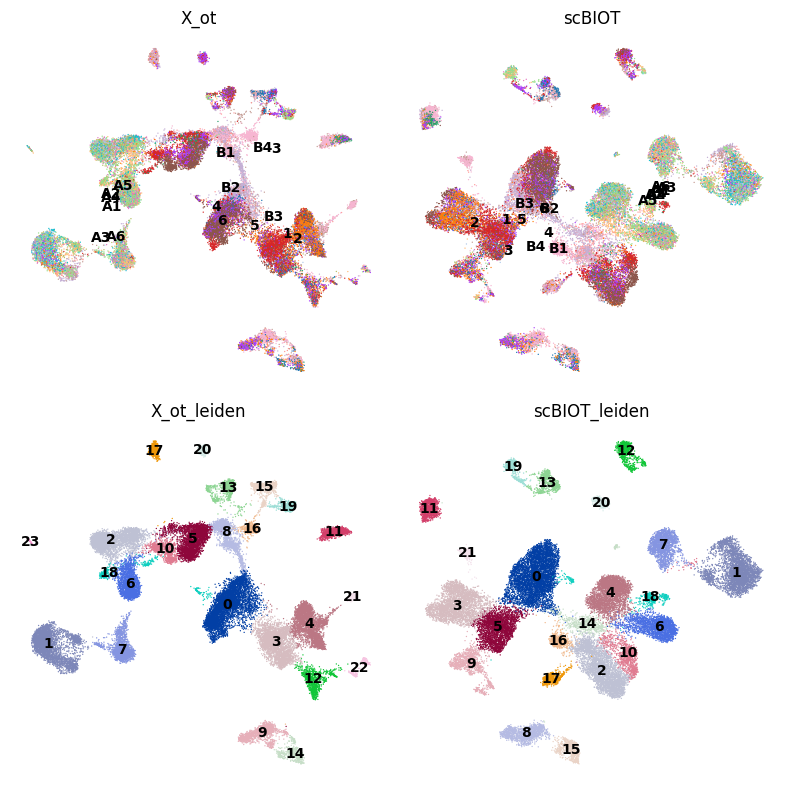

In [17]:
import matplotlib.pyplot as plt
import scanpy as sc


# 2 rows x len(methods) columns
fig, axes = plt.subplots(
    2,
    len(methods),
    figsize=(4 * len(methods), 8),
    squeeze=False  # ensures axes is a 2D array
)

for col, method in enumerate(methods):
    # 1) Top row (row=0): color by "batch"
    sc.pl.embedding(
        adata,
        basis=f"X_umap_{method}",  # The coordinates stored in adata.obsm["X_umap_{method}"]
        color="batch",            # Assume adata.obs["batch"] exists
        frameon=False,
        ax=axes[0, col],
        show=False,
        legend_loc="on data",
        legend_fontsize=10,  # smaller font
        title=f"{method}"
    )

    # 2) Bottom row (row=1): color by the Leiden clusters for this method
    leiden_key = f"{method}_leiden"
    sc.pl.embedding(
        adata,
        basis=f"X_umap_{method}",
        color=leiden_key,         # Column in adata.obs
        frameon=False,
        ax=axes[1, col],
        show=False,
        legend_loc="on data",
        legend_fontsize=10,  # smaller font
        # title=f"{method}"
    )

plt.tight_layout()
# fig.savefig("batch_and_leiden_per_embedding.pdf", dpi=300)
# plt.close(fig)


In [18]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'leiden_X_ot', 'X_ot_leiden', 'scBIOT_leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden_X_ot', '_scbiot_setup', 'X_ot_leiden', 'scBIOT_leiden', 'batch_colors', 'X_ot_leiden_colors', 'scBIOT_leiden_colors'
    obsm: 'X_pca', 'X_ot', 'X_umap', 'scBIOT', 'X_umap_X_ot', 'X_umap_scBIOT'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [19]:
# fix the bug in the scib-metrics
# change _graph_connectivity.py: <mask = labels == label> to <mask = (labels == label).to_numpy()> 



In [20]:
bm = Benchmarker(
    adata, 
    batch_key="batch",
    label_key="cell_type",
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),    
    embedding_obsm_keys=["X_pca", "X_ot","scBIOT"], 
    n_jobs=-1
    
)
bm.benchmark()

Embeddings: 100%|██████████| 3/3 [01:54<00:00, 38.01s/it]


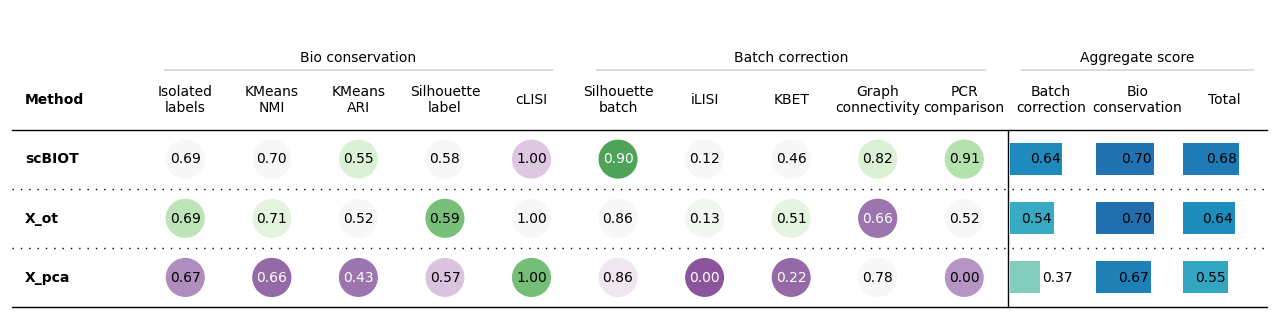

In [21]:
bm.plot_results_table(min_max_scale=False)